<a href="https://colab.research.google.com/github/alwaysneedhelp/Practice-for-IOAI/blob/main/2025_IOAI_home_task_solution_RADAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Radar

Radar is a key technology in wireless communication, with widespread applications such as self-driving cars. It typically involves an antenna that transmits specific signals and receives their reflections from objects in the environment. By processing these signals, the system determines the angular direction, distance, and velocity of target objects.

In real-world applications, radar signal processing is challenging due to noise and reflections from non-target objects in the surroundings. For example, when attempting to detect pedestrians, the radar may also receive reflections from trees or other background objects, which can degrade accuracy. Your task is to use AI to analyze the signals received by the radar and identify the presence of a human at each position.

## Data

To measure objects surrounding a radar, the following key parameters are used:

- **Range**: The straight-line distance between the radar and an object.
- **Azimuth**: The horizontal angle (left to right) between the radar and the object.
- **Elevation**: The vertical angle (up or down) of the object relative to the radar.
- **Velocity**: The speed at which the object is moving toward or away from the radar.

<div align="center">
  <img src="https://drive.google.com/uc?id=1GcNNWdXVgFx99nMCIAr97xDVbvb2CdGC" alt="Azimuth angle visualization" width="300" />
</div>

The radar data is processed into multiple **heatmaps**, each encoding the **received signal strength** at various positions and directions.  
- **Static heatmaps** emphasize reflections from **stationary** objects.  
- **Dynamic heatmaps** highlight changes caused by **moving** objects.  

When no object is present at a specific location, the signal consists mostly of background noise and appears weak. In contrast, reflections from an object increase signal intensity, enabling detection of the object.

For example, the **static range-azimuth heatmap** represents signal strength across different distances (**range**) and horizontal angles (**azimuth**), mainly reflected by stationary objects.

Each sample in the dataset is stored in a `.mat.pt` file as a tensor of shape $7 \times 50 \times 181$, where:
- $7$ is the number of maps (6 heatmaps + 1 semantic label map),
- $50$ represents range bins (distance),
- $181$ represents angular bins, covering angles from $-90^\circ$ to $+90^\circ$ in either the horizontal or vertical plane.

The 6 heatmaps are structured as follows:

- **Index 0**: Static range-azimuth heatmap  
- **Index 1**: Dynamic range-azimuth heatmap  
- **Index 2**: Static range-elevation heatmap  
- **Index 3**: Dynamic range-elevation heatmap  
- **Index 4**: Static range-velocity heatmap  
- **Index 5**: Dynamic range-velocity heatmap  

All values in heatmaps are **normalized**, so no unit conversion is required.

The **map at Index 6** is the semantic label map, stored in range-azimuth format. Each pixel indicates whether a human target is present at that position, using binary values:
- **0**: Human absent  
- **1**: Human present

Here is part of a sample from the dataset:

![Sample data](https://drive.google.com/uc?id=1DTymwNDRnGAeBxKR-CdaBEqgeNv1rGBe)

## Task

Your task is to develop a model that takes the **first six heatmaps** (indices $0$ to $5$) as input, and predicts the **semantic label map** (index $6$) as the output. The goal is to accurately identify whether a **human target** is present (1) or absent (0) at each location in the radar’s field of view.

1. **Input**: A tensor of shape **$6 \times 50 \times 181$**, representing six radar heatmaps.  
2. **Output**: A tensor of shape **$50 \times 181$**, representing the target semantic label map.  

## Accessing Data
You can download the training_set and validation_set through the link below

In [1]:
!pip install gdown

In [2]:
!gdown https://drive.google.com/uc?id=1mXqBIqSfHif3LvJ7Jce1C7addqdfu7B-
!unzip Millimeter-wave_dataset.zip

Downloading...
From (original): https://drive.google.com/uc?id=1mXqBIqSfHif3LvJ7Jce1C7addqdfu7B-
From (redirected): https://drive.google.com/uc?id=1mXqBIqSfHif3LvJ7Jce1C7addqdfu7B-&confirm=t&uuid=4c985657-382f-44f0-bd90-f4fea0745dd4
To: /content/Millimeter-wave_dataset.zip
100% 937M/937M [00:11<00:00, 79.3MB/s]
Archive:  Millimeter-wave_dataset.zip
   creating: training_set/
  inflating: __MACOSX/._training_set  
  inflating: training_set/1503.mat.pt  
  inflating: __MACOSX/training_set/._1503.mat.pt  
  inflating: training_set/1252.mat.pt  
  inflating: __MACOSX/training_set/._1252.mat.pt  
  inflating: training_set/1403.mat.pt  
  inflating: __MACOSX/training_set/._1403.mat.pt  
  inflating: training_set/1352.mat.pt  
  inflating: __MACOSX/training_set/._1352.mat.pt  
  inflating: training_set/1098.mat.pt  
  inflating: __MACOSX/training_set/._1098.mat.pt  
  inflating: training_set/994.mat.pt  
  inflating: __MACOSX/training_set/._994.mat.pt  
  inflating: training_set/1198.mat.pt  

## Dataset Visualization
You can select a piece of data for visualization to understand the specific content represented by each heatmap.

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec

def visualize_pt_file(file_path):
    data = torch.load(file_path)
    print(f"Loaded data shape: {data.shape}")
    num_images = data.shape[0]
    cols = 3
    rows = (num_images + cols - 1) // cols

    fig = plt.figure(figsize=(cols * 5.5, rows * 5.5), constrained_layout=True)

    gs = gridspec.GridSpec(rows, cols, figure=fig)

    colors = ['black', 'yellow']
    cmap_discrete = ListedColormap(colors)

    for i in range(num_images):
        img = data[i].numpy().squeeze()
        img = np.flipud(img)

        if i < 6:
            ax = fig.add_subplot(gs[i // cols, i % cols], projection='polar')
            height, width = img.shape
            angles = np.linspace(-90, 90, width)
            distances = np.linspace(0, 50, height)
            angles_rad = np.radians(angles)
            theta, r = np.meshgrid(angles_rad, distances)
            im = ax.pcolormesh(theta, r, img, shading='auto')

            ax.set_thetalim(np.radians(-90), np.radians(90))
            ax.set_rlim(0, 50)
            ax.set_thetagrids(np.arange(-90, 91, 30))
            ax.set_rticks([0, 10, 20, 30, 40, 50])
            ax.set_rlabel_position(45)
            ax.set_title(f'Index {i}', pad=20)

            plt.colorbar(im, ax=ax, shrink=0.8, label='Intensity')

        else:
            ax = fig.add_subplot(gs[2, :])
            height, width = img.shape
            img_normalized = img + 1
            im = ax.imshow(img_normalized, extent=[-90, 90, 0, height],
                          cmap=cmap_discrete, vmin=0, vmax=4, aspect='auto')

            ax.set_xlabel('X Axis')
            ax.set_ylabel('Y Axis')
            ax.set_title(f'Index {i} (Labels)')

            x_ticks = np.linspace(-90, 90, 7)
            ax.set_xticks(x_ticks)
            ax.set_xticklabels([f'{int(x)}' for x in x_ticks])

            y_ticks = np.linspace(0, height, 6)
            ax.set_yticks(y_ticks)
            ax.set_yticklabels([f'{int(y)}' for y in y_ticks])

            ax.grid(True, linestyle='--', alpha=0.5)

            legend_elements = [
                Patch(facecolor='black', label='Background'),
                Patch(facecolor='yellow', label='Human')
            ]

            ax.legend(handles=legend_elements,
                      loc='best',
                      fontsize='large')

    plt.show()

Loaded data shape: torch.Size([7, 50, 181])


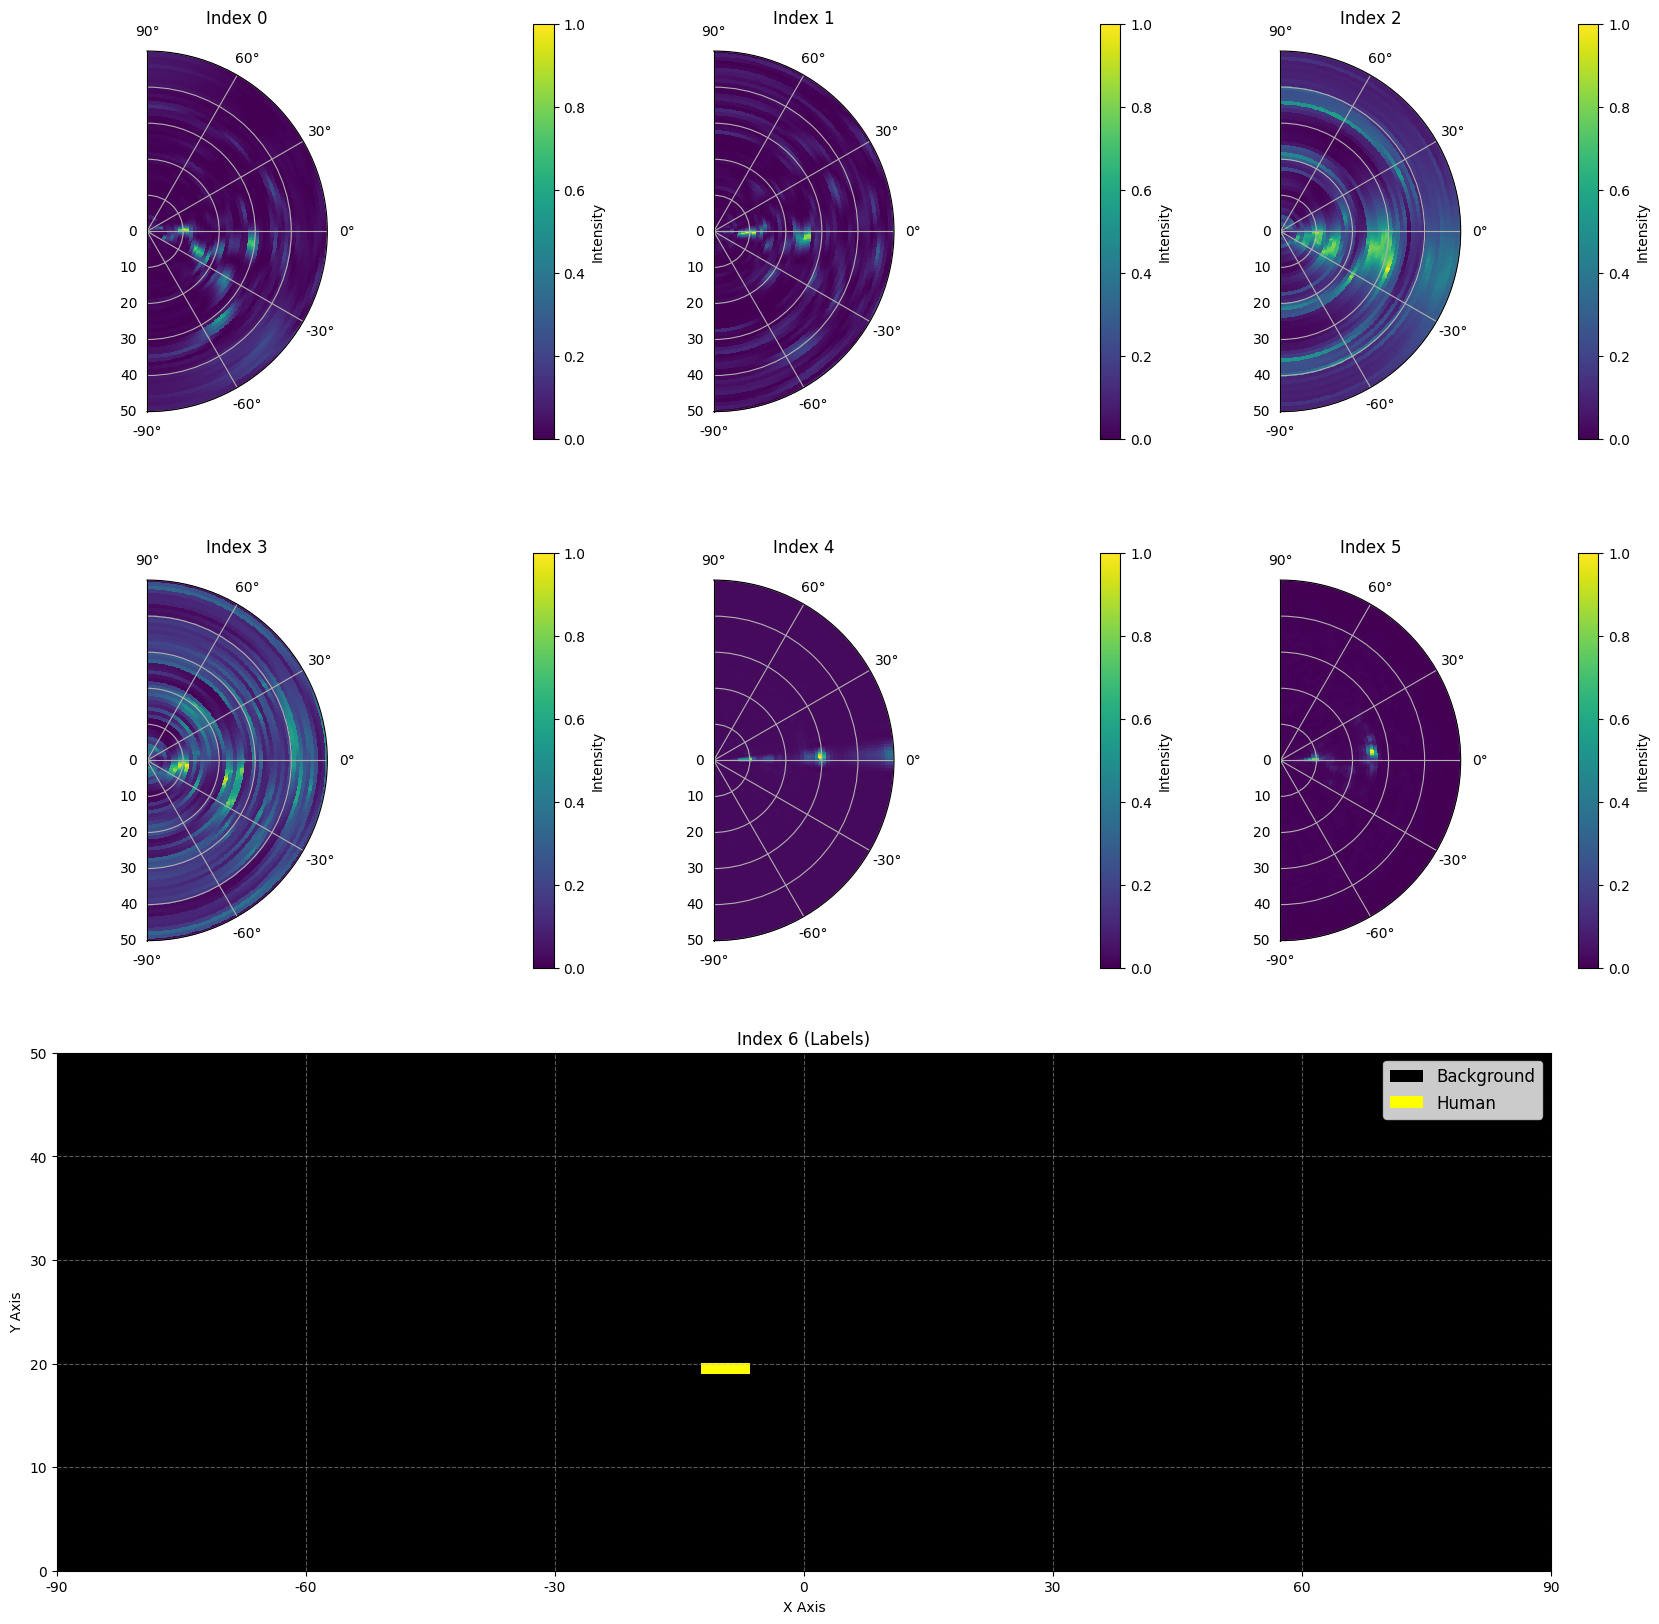

In [4]:
file_path = f'/content/training_set/1.mat.pt'
visualize_pt_file(file_path)

## Scoring
The score for this task is based on the **accuracy of label recognition**. Correctly identifying target points is weighted more heavily than correctly identifying background points.  

More specifically:
- Each correctly identified **background point** earns **1 point**.  
- Each correctly identified **target point** earns **1500 points**.  
- The final score is normalized to a **0-1 scale** by comparing it to the maximum possible score.  

The following function calculates your score:

In [5]:
import torch
def cal_accuracy(model, test_loader, bonus):
    model.eval()
    total_score = 0
    total_theo = 0

    with torch.no_grad():
        for images, labels, _ in test_loader:
            images = images.cuda() if torch.cuda.is_available() else images
            labels = labels.cuda() if torch.cuda.is_available() else labels

            outputs = model(images)
            outputs = torch.argmax(outputs, dim=1)

            equal_mask = outputs == labels  # correctly predicted masks
            neg_one_mask = labels == 0      # Mask of background categories

            # Calculate the score
            score_neg_one = (equal_mask & neg_one_mask).sum() * 1  # Background category score
            score_other = (equal_mask & ~neg_one_mask).sum() * bonus  # Target category score
            score_theo = neg_one_mask.sum() * 1 + (~neg_one_mask).sum() * bonus  # Full marks in theory

            total_score += score_neg_one + score_other
            total_theo += score_theo

    score = total_score.item() / total_theo.item()
    return score

## Example
For a $3\times3$ heatmap, assume the Ground Truth is
$$
\begin{bmatrix}
0 & 0 & 0 \\
1 & 1 & 1 \\
0 & 0 & 0
\end{bmatrix}
$$
The result you identified is
$$
\begin{bmatrix}
0 & 1 & 0 \\
0 & 1 & 0 \\
0 & 1 & 0
\end{bmatrix}
$$
Then there are four correctly identified $0$ and one correctly identified $1$. Your score is $4 + 1500 = 1504$ points. The maximum possible score is $6 + 1500 \times 3 = 4506$, that is, the score for six $0$s and three $1$s. Your normalized score is 1504 / 4506 = 0.33.
$$
Score = \frac{4 \times 1 + 1 \times 1500}{6 \times 1 + 3 \times 1500}=0.33
$$

In [6]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform
        self.file_names = [os.path.basename(path) for path in file_paths]

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        data = torch.load(self.file_paths[idx], weights_only=True)

        images = data[:6]
        labels = data[6]

        images = images.float()
        labels = labels.long()

        if self.transform:
            images = self.transform(images)
            labels = self.transform(labels)

        return images, labels, self.file_names[idx]

def generate_file_paths(base_path):
    file_paths = []
    for frame in os.listdir(base_path):
        frame_path = os.path.join(base_path, frame)
        if frame_path.endswith('.mat.pt'):
            file_paths.append(frame_path)
    return [path for path in file_paths if os.path.exists(path)]

def load_data(base_path, batch_size=4, num_workers=2, test_size=0.2):
    file_paths = generate_file_paths(base_path)

    train_paths, test_paths = train_test_split(file_paths, test_size=test_size, random_state=42)

    train_dataset = CustomDataset(file_paths=train_paths)
    test_dataset = CustomDataset(file_paths=test_paths)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        drop_last=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        drop_last=True
    )

    return train_loader, test_loader


In [51]:
data_path = './training_set'
train_loader, test_loader = load_data(
    base_path=data_path,
    batch_size=4,
    test_size=0.2
)

In [67]:

import torchvision
import torch.nn as nn
import torch.optim as optim
import torch



class MyModel(nn.Module):


  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = nn.Conv2d(6,16,3, padding=1)
    self.conv2 = nn.Conv2d(16,32,3, padding=1)
    self.conv3 = nn.Conv2d(32,2,3, padding=1)

    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.relu(self.conv2(x))
    x = self.conv3(x)

    return x

In [72]:
def train(model, optimizer, train_loader, loss_function, epochs=30):

  model.train()

  for epoch in range(epochs):
    print(f'Training epoch {epoch}...')


    epoch_loss = 0
    batch_size = 0


    for inputs, labels, _ in train_loader:


      outputs = model(inputs)
      outputs = outputs.view(outputs.size(0), outputs.size(1), -1)  # [B, C, H*W]
      labels = labels.view(labels.size(0), -1)  # [B, H*W]
      loss = loss_function(outputs, labels)

      epoch_loss += loss.item()
      batch_size += 1

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    print(f'Loss: {epoch_loss/batch_size:.4f}')

In [73]:
def evaluate(model, test_loader, loss_function):
  total_loss = 0
  total = 0

  model.eval()

  with torch.no_grad():
    for inputs, labels, _ in test_loader:
        outputs = model(inputs)

        outputs = outputs.view(outputs.size(0), outputs.size(1), -1)  # [B, C, H*W]
        labels = labels.view(labels.size(0), -1)  # [B, H*W]
        loss = loss_function(outputs, labels)

        total += 1
        total_loss += loss.item()

  print('-------------------------------------------------------------------')
  print(f'-------------------Final loss is {total_loss/total}---------------')

In [74]:
model = MyModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
class_weights = torch.tensor([1.,1500.])
loss_function = nn.CrossEntropyLoss(weight=class_weights)

In [75]:
train(
    model=model,
    optimizer = optimizer,
    train_loader=train_loader,
    loss_function=loss_function
)

Training epoch 0...
Loss: 0.3023
Training epoch 1...
Loss: 0.1937
Training epoch 2...
Loss: 0.1593
Training epoch 3...
Loss: 0.1318
Training epoch 4...
Loss: 0.1164
Training epoch 5...
Loss: 0.1137
Training epoch 6...
Loss: 0.1003
Training epoch 7...
Loss: 0.0911
Training epoch 8...
Loss: 0.0834
Training epoch 9...
Loss: 0.0785
Training epoch 10...
Loss: 0.0758
Training epoch 11...
Loss: 0.0699
Training epoch 12...
Loss: 0.0647
Training epoch 13...
Loss: 0.0639
Training epoch 14...
Loss: 0.0644
Training epoch 15...
Loss: 0.0568
Training epoch 16...
Loss: 0.0606
Training epoch 17...
Loss: 0.0530
Training epoch 18...
Loss: 0.0551
Training epoch 19...
Loss: 0.0522
Training epoch 20...
Loss: 0.0496
Training epoch 21...
Loss: 0.0465
Training epoch 22...
Loss: 0.0479
Training epoch 23...
Loss: 0.0450
Training epoch 24...
Loss: 0.0454
Training epoch 25...
Loss: 0.0454
Training epoch 26...
Loss: 0.0428
Training epoch 27...
Loss: 0.0394
Training epoch 28...
Loss: 0.0446
Training epoch 29...
Los

In [76]:
evaluate(
    model=model,
    test_loader=test_loader,
    loss_function=loss_function
)

-------------------------------------------------------------------
-------------------Final loss is 0.11642702296376228---------------
